**Importing Dependencies**

In [2]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v6 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [3]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [4]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


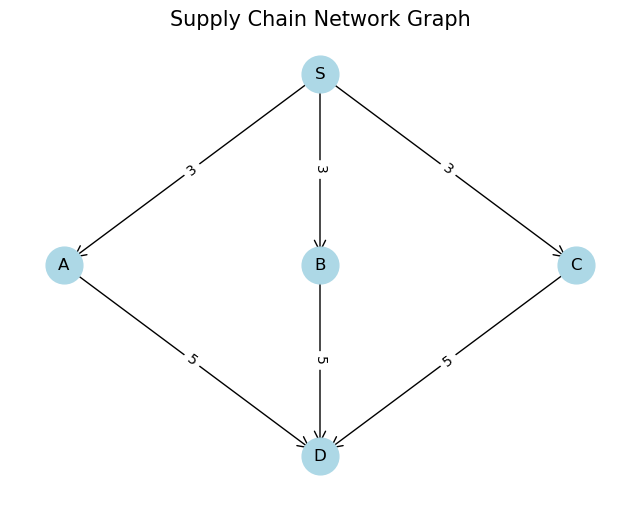

In [5]:
env.render_network()

In [6]:
env.state.shape

(93,)

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [8]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

# 30, 28, 32

Episode Length: 1
Stock Level: [[22. 28. 32.]]
Planned Demand: [8. 0. 0.]
Actual Demand: [8. 0. 0.]
Action: [15, 0, 50]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 50], maxlen=3)}

Episode Length: 2
Stock Level: [[13. 28. 32.]]
Planned Demand: [6. 0. 4.]
Actual Demand: [9. 0. 0.]
Action: [0, 50, 15]
Order: [0 0 0]
Reward: 102.5

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 15, 0], maxlen=3),
    'B': deque([0, 0, 50], maxlen=3),
    'C': deque([0, 50, 15], maxlen=3)}

Episode Length: 3
Stock Level: [[13. 21. 32.]]
Planned Demand: [0. 9. 0.]
Actual Demand: [0. 7. 0.]
Action: [50, 50, 0]
Order: [0 0 0]
Reward: 127.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([15, 0, 50], maxlen=3),
    'B': deque([0, 50, 50], maxlen=3),
    'C': deque([50, 15, 0], maxle

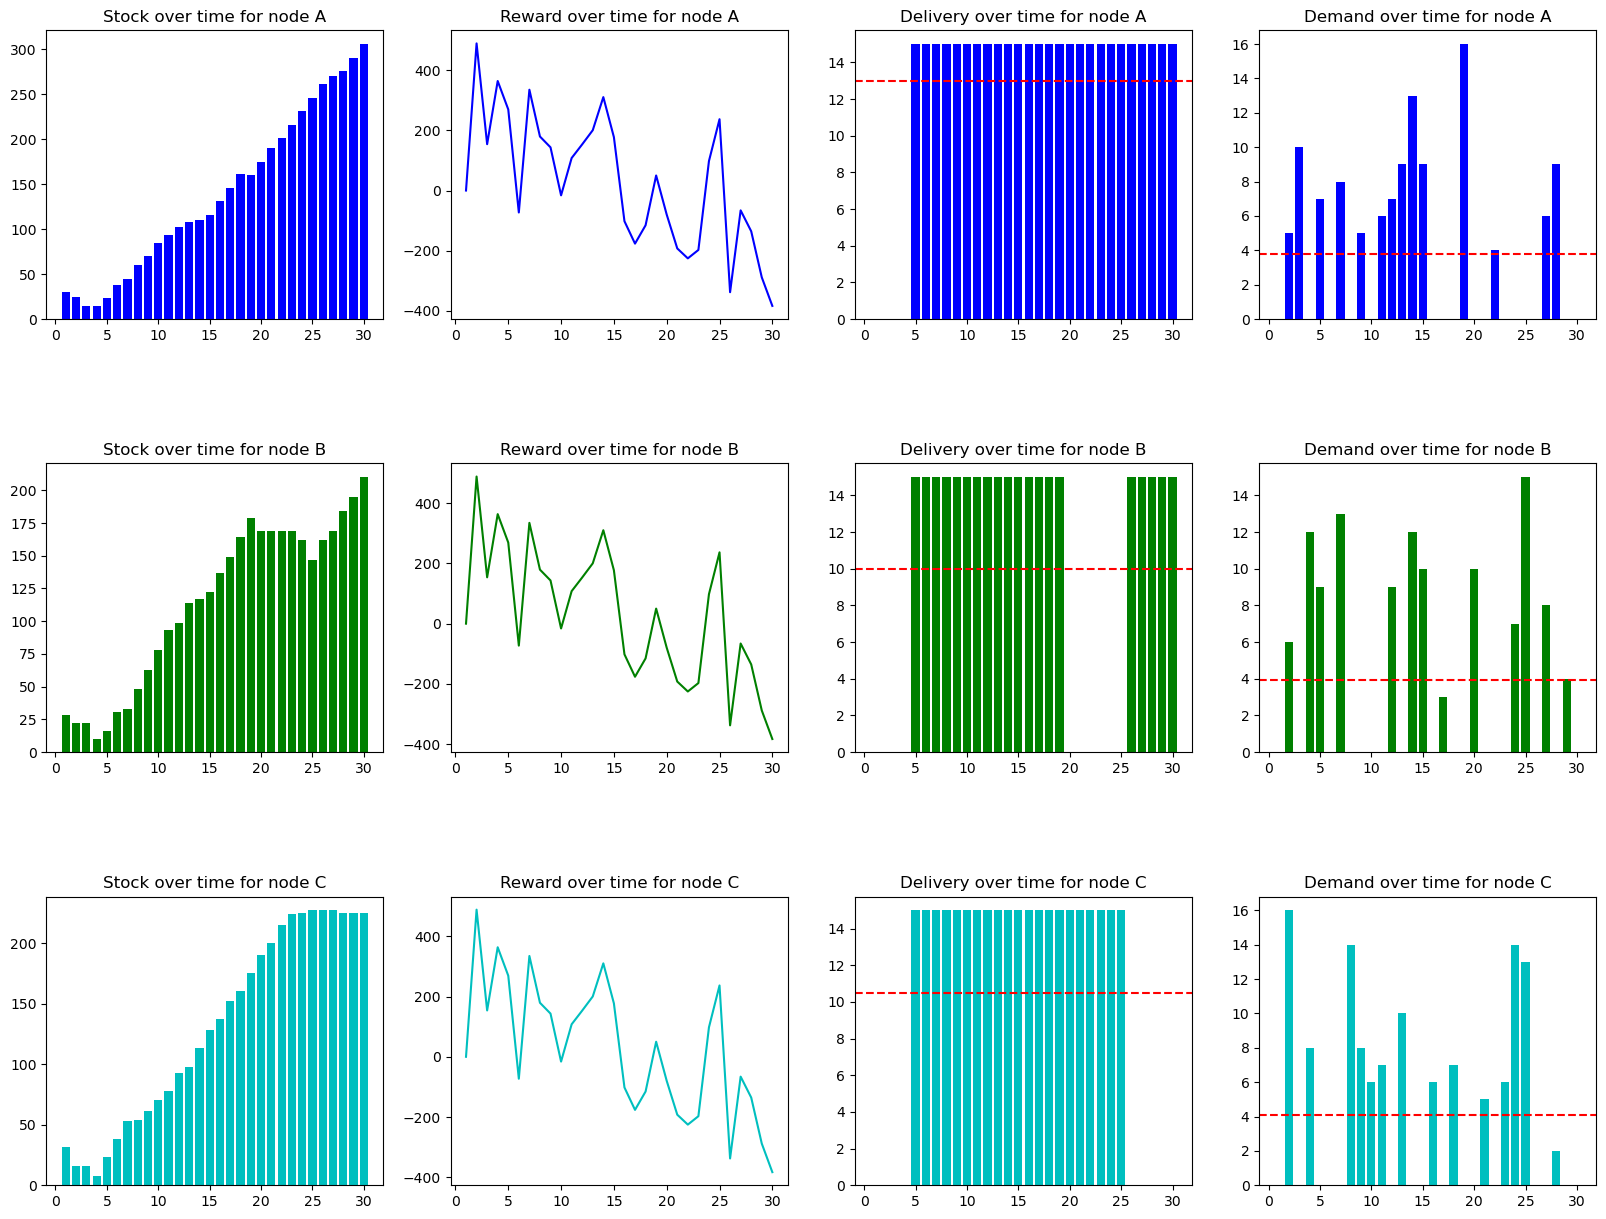

In [9]:
df = pd.read_csv('./Data/2024-10-19_15_last_environment_data.csv')
plot_data(df)

**Train Model**


In [19]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')
# model_path = os.path.join('Training', 'Models', 'A2C')

In [20]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

# num_envs = 8

dummy_env = DummyVecEnv([lambda: env])
# vec_env = make_vec_env(make_env, n_envs=num_envs)

model = PPO("MlpPolicy", 
            dummy_env,
            learning_rate = 0.0007, # 0.0003
            gamma = 0.99, # 0.95
            verbose=1,
            tensorboard_log=log_path)

# model = A2C("MlpPolicy",
#             vec_env,
#             learning_rate = 0.0005,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

# model = A2C(
#     "MlpPolicy",
#     vec_env,
#     learning_rate=0.0003,           # Lower learning rate for smoother updates
#     gamma=0.95,                      # Slightly lower discount factor for faster convergence on immediate rewards
#     ent_coef=0.01,                   # Add an entropy coefficient to encourage exploration
#     verbose=1,
#     tensorboard_log=log_path,
# )

Using cpu device


In [21]:
model.learn(total_timesteps=1_000_000)

Logging to Training/Logs/PPO_76
-----------------------------
| time/              |      |
|    fps             | 3356 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2170        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008483531 |
|    clip_fraction        | 0.0782      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.29       |
|    explained_variance   | -9.32e-05   |
|    learning_rate        | 0.0007      |
|    loss                 | 2.5e+06     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 4.86e+06    |
-----------------------------------------
--

In [22]:
model.save(model_path)
model.load(model_path)

# evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)
evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [[30. 28. 32.]]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [0, 0, 0]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode Length: 2
Stock Level: [[22. 28. 25.]]
Planned Demand: [8. 0. 9.]
Actual Demand: [8. 0. 7.]
Action: [0, 0, 0]
Order: [0 0 0]
Reward: -45.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode Length: 3
Stock Level: [[15. 28. 25.]]
Planned Demand: [8. 0. 0.]
Actual Demand: [7. 0. 0.]
Action: [0, 0, 0]
Order: [0 0 0]
Reward: 262.5

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode Len

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([4601.0], [30])

In [23]:
file = './Data/2024-11-04_16_last_environment_data.csv'
df = pd.read_csv(file)

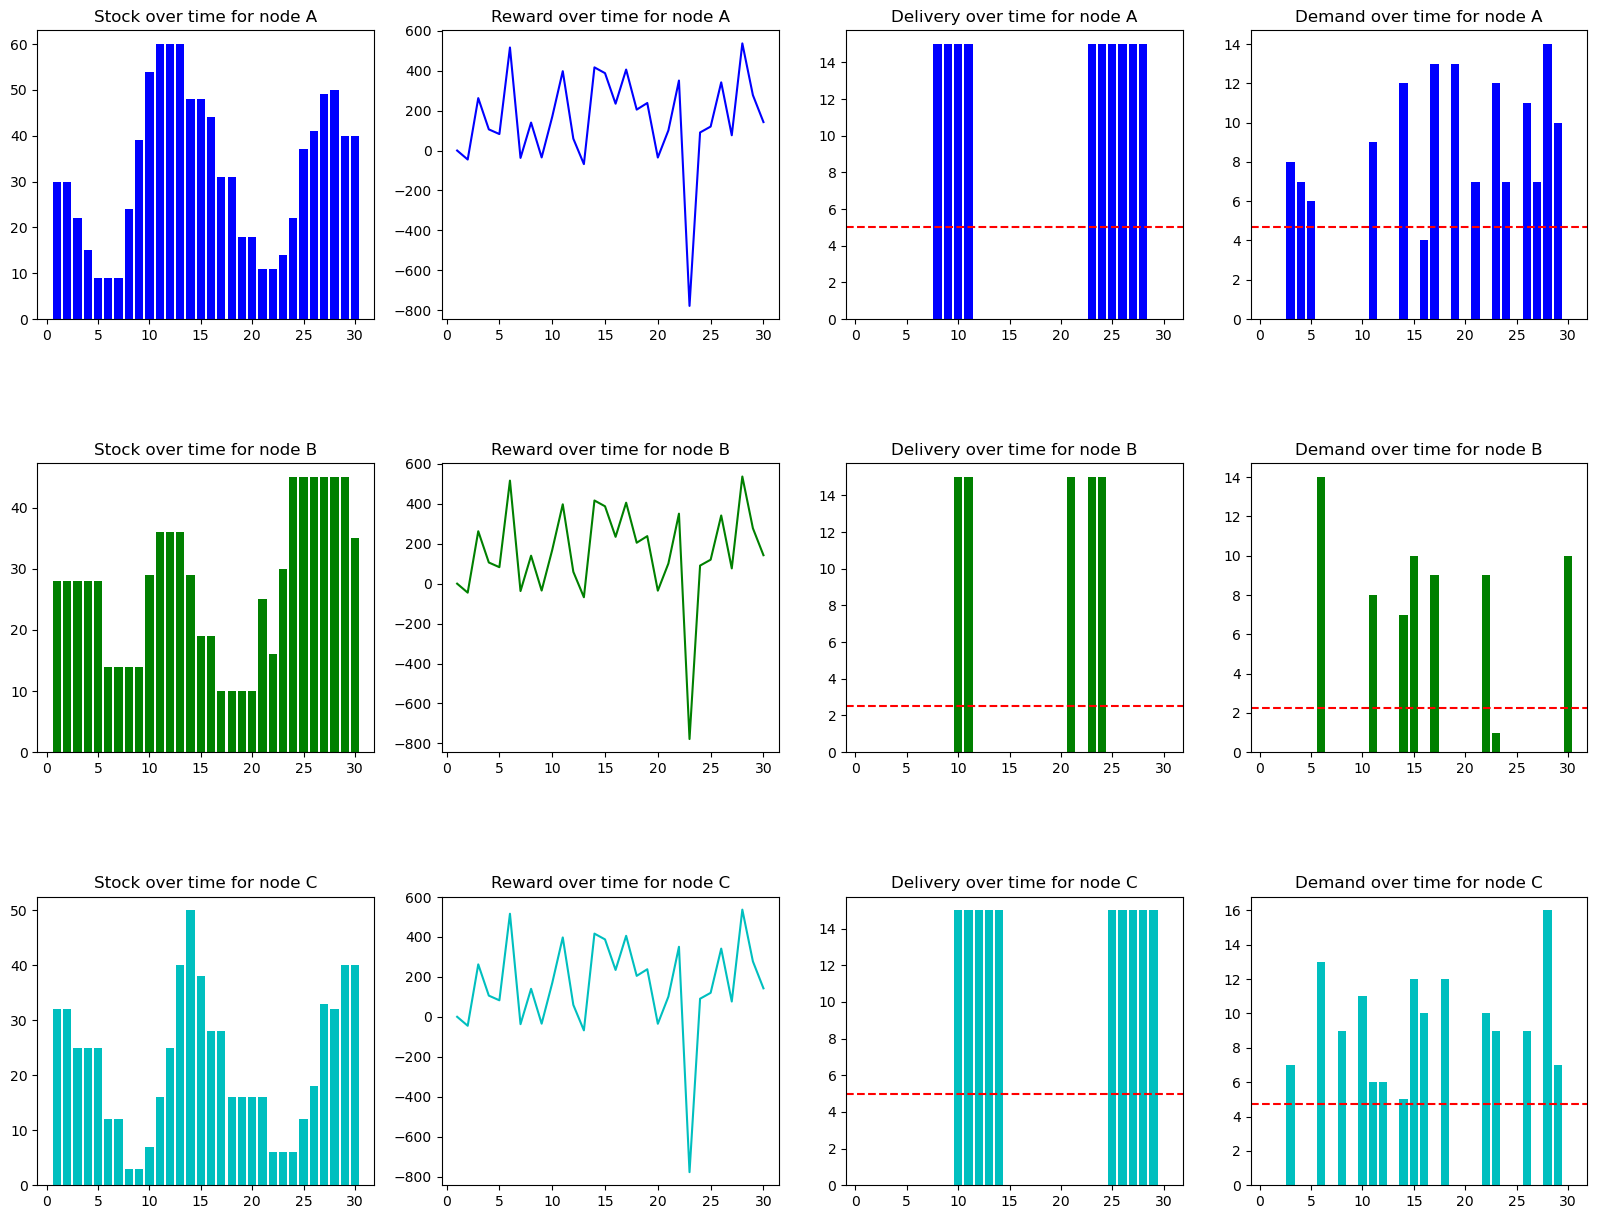

In [24]:
plot_data(df)